## Cosmological Parameters from $\kappa$ maps with Vision Transformers (ViT)

We predict the $\Omega_m, \sigma_8$ cosmological parameters from mass maps.

In [ ]:
#! apt-get update
#!sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super
#!pip install chainconsumer

In [ ]:
# Useful for ViTs
#!pip install -U tensorflow-addons

**Install basic packages**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn import metrics

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Import basic packages
import scipy as sp
import pandas as pd


# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### **Load the dataset**

In [ ]:
# Mount drive to upload the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Define the data path
DATA_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Datasets/'

# IMAGE PATH
IMG_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Plots/'

# MODEL WEIGHTS PATH
MDL_WEIGHTS_PATH = '/content/drive/My Drive/Maps_Project/Deliverables_Maps/Saved_Models/'

In [ ]:
# Load maps
X_maps = np.float64(np.load(DATA_PATH+"X_maps_Cosmogrid_100k.npy",mmap_mode='r'))

# Load labels
y_cosmo = np.float64(np.load(DATA_PATH+"y_maps_Cosmogrid_100k.npy"))

### Split into training, validation, and test sets

In [ ]:
# Keep a number of maps for training, validation, and testing
X_train = X_maps[:50000].reshape(50000,66,66,1)
X_val = X_maps[80000:90000].reshape(10000,66,66,1)
X_test = X_maps[90000:].reshape(10000,66,66,1)

# Delete the full, large dataset to free memory
del X_maps

In [ ]:
# Garbage collector to free up memory
import gc
gc.collect()

26

In [ ]:
# Get omega and sigma 8
y_Omega = y_cosmo[:,0];y_sigma_8 = y_cosmo[:,3]

# Labels for two cosmological parameters 
y_cosmo_2 = np.stack([y_Omega,y_sigma_8],axis=-1)

# Split into training, validation, test sets
y_train  = y_cosmo_2[:50000]
y_val = y_cosmo_2[80000:90000]
y_test = y_cosmo_2[90000:]


# Delete what we do not need any more
del y_cosmo_2, y_cosmo, y_Omega, y_sigma_8

In [ ]:
# Rescale the labels


# Define the scaler
scaler = MinMaxScaler()

# Fit the scaler 
scaler.fit(y_train)

# Rescale
y_train_sc = scaler.transform(y_train)
y_val_sc = scaler.transform(y_val)
y_test_sc = scaler.transform(y_test)

In [ ]:
print(np.shape(y_train))

(50000, 2)


In [ ]:
print(np.shape(X_train))

(50000, 66, 66, 1)


### **Train a Vision Transformer (ViT)**

(Based on the Keras example)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 66  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 128
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
num_classes = 2
input_shape = (66,66,1)

### Use data augmentation

In [ ]:

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

### Implement a MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Implement patch creation as a layer


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's display a randomly selected image

Image size: 66 X 66
Patch size: 8 X 8
Patches per image: 64
Elements per patch: 64


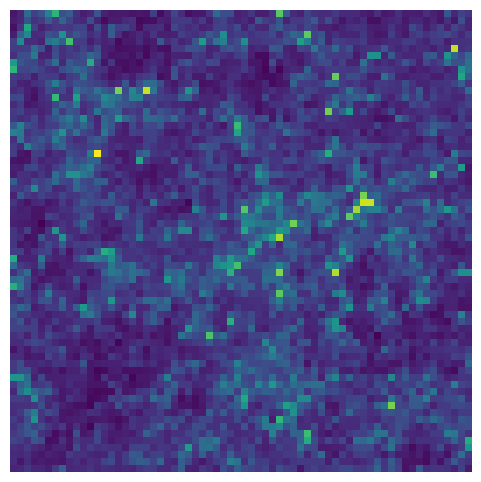

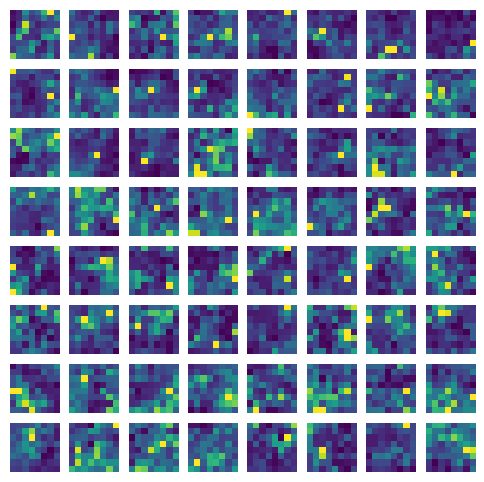

In [ ]:
plt.figure(figsize=(6, 6))
img_id = np.random.choice(range(X_train.shape[0]))
image = X_train[img_id]
plt.imshow(image[:,:])
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(6, 6))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy()[:,:])
    plt.axis("off")

### Implement a patch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Build ViT model

In [ ]:
tf.keras.backend.clear_session()

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2, activation='linear')(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
     

In [ ]:
model = create_vit_classifier()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
      optimizer=optimizer,
      loss= 'MSE',
      metrics=['MAE'])

In [ ]:
n_epochs = 20
model.fit(x=X_train, y=y_train_sc,
          epochs=n_epochs, batch_size=128,
          shuffle=True,
          validation_data=(X_val,y_val_sc))

Epoch 1/20
391/391 [==============================] - 92s 153ms/step - loss: 1.0850 - MAE: 0.3299 - val_loss: 0.0472 - val_MAE: 0.1756
Epoch 2/20
391/391 [==============================] - 58s 148ms/step - loss: 0.0474 - MAE: 0.1721 - val_loss: 0.0236 - val_MAE: 0.1215
Epoch 3/20
391/391 [==============================] - 59s 151ms/step - loss: 0.0344 - MAE: 0.1455 - val_loss: 0.0214 - val_MAE: 0.1153
Epoch 4/20
391/391 [==============================] - 59s 150ms/step - loss: 0.0293 - MAE: 0.1344 - val_loss: 0.0216 - val_MAE: 0.1153
Epoch 5/20
391/391 [==============================] - 59s 151ms/step - loss: 0.0265 - MAE: 0.1278 - val_loss: 0.0228 - val_MAE: 0.1163
Epoch 6/20
391/391 [==============================] - 59s 150ms/step - loss: 0.0245 - MAE: 0.1227 - val_loss: 0.0206 - val_MAE: 0.1143
Epoch 7/20
391/391 [==============================] - 59s 150ms/step - loss: 0.0230 - MAE: 0.1189 - val_loss: 0.0175 - val_MAE: 0.1051
Epoch 8/20
391/391 [==============================] - 5

KeyboardInterrupt: ignored

In [ ]:
y_preds_test = model.predict(X_test)

print(np.shape(y_preds_test))

y_preds_test_unsc = scaler.inverse_transform(np.asarray(y_preds_test))

313/313 [==============================] - 6s 16ms/step
(10000, 2)


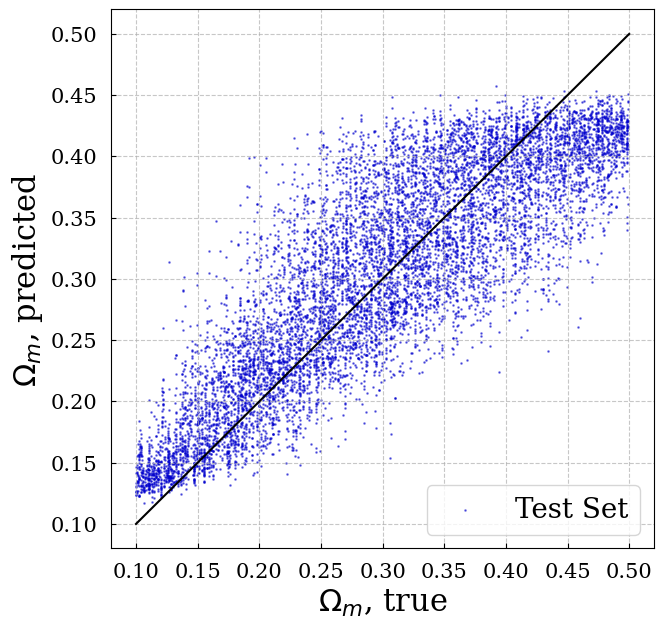

In [ ]:
plt.figure(figsize=(7,7))

x_lin = np.linspace(0.1,0.5,100)


#plt.scatter(y_cosmo_train[:,0],y_preds_train_unsc[:,0],s=0.8,c='maroon', alpha=0.5, label='Training Set')
plt.scatter(y_test[:,0],y_preds_test_unsc[:,0],s=0.8,c='mediumblue',alpha=0.5, label="Test Set")

plt.plot(x_lin,x_lin,c='k')

plt.xlabel('$\Omega_m$, true', fontsize=22)
plt.ylabel('$\Omega_m$, predicted', fontsize=22)
plt.xticks(fontsize=15);plt.yticks(fontsize=15)
plt.grid(ls='--',alpha=0.7)
plt.legend(frameon=True, loc='lower right', fontsize=20)


#plt.savefig(PLT_PATH+"Omega_preds_old.pdf")
plt.show()

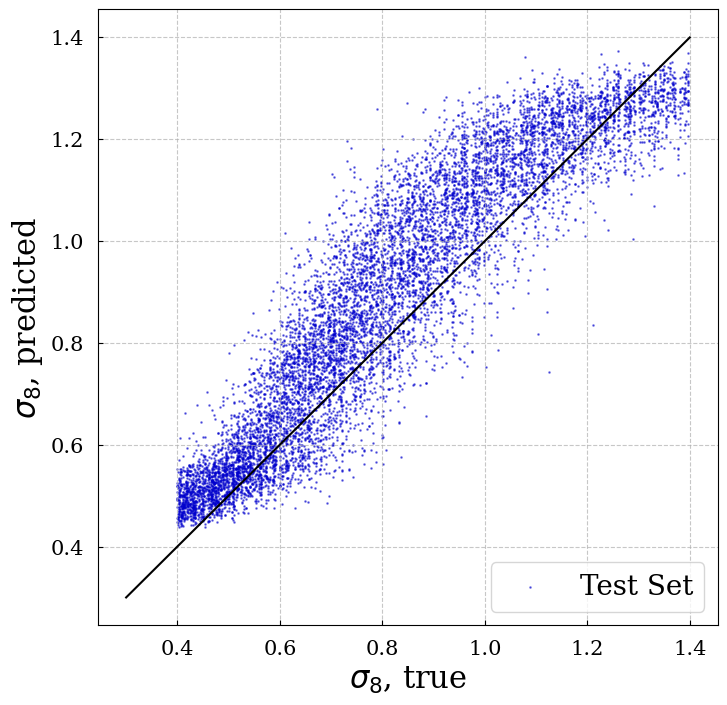

In [ ]:
plt.figure(figsize=(8,8))

x_lin = np.linspace(0.3,1.4,100)


plt.scatter(y_test[:,1],y_preds_test_unsc[:,1],s=0.8,c='mediumblue',alpha=0.5, label='Test Set')

plt.plot(x_lin,x_lin,c='k')

plt.xlabel('$\sigma_8$, true', fontsize=22)
plt.ylabel('$\sigma_8$, predicted', fontsize=22)
plt.grid(ls='--',alpha=0.7)
plt.xticks(fontsize=15);plt.yticks(fontsize=15)

plt.legend(frameon=True, loc='lower right', fontsize=20)
#plt.savefig(PLT_PATH+"Sigma_preds_old.pdf")

plt.show()